## Image Captioning using KNN

Although VLMs (Vision Language Models) are the go to tools for image captioning right now, there are interesting works from earlier years that used KNN for captioning and perform surprisingly well enough!

Further, Libraries like [Faiss](https://engineering.fb.com/2017/03/29/data-infrastructure/faiss-a-library-for-efficient-similarity-search/) perform the nearest neighbor computation efficiently and are used in many industrial applications.

- In this question you will implement an algorithm to perform captioning using KNN based on the paper [A Distributed Representation Based Query Expansion Approach for
Image Captioning](https://aclanthology.org/P15-2018.pdf)

- Dataset: [MS COCO](https://cocodataset.org/#home) 2014 (val set only)

- Algorithm:
    1. Given: Image embeddings and correspond caption embeddings (5 Per image)
    1. For every image, findout the k nearest images and compute its query vector as the weighted sum of the captions of the nearest images (k*5 captions per image)
    1. The predicted caption would be the caption in the dataset that is closest to the query vector. (for the sake of the assignment use the same coco val set captions as the dataset)

- The image and text embeddings are extracted from the [CLIP](https://openai.com/research/clip) model. (You need not know about this right now)

- Tasks:
    1. Implement the algorithm and compute the bleu score. Use Faiss for nearest neighbor computation. Starter code is provided below.
    1. Try a few options for k. Record your observations.
    1. For a fixed k, try a few options in the Faiss index factory to speed the computation in step 2. Record your observations.
    1. Qualitative study: Visualize five images, their ground truth captions and the predicted caption.
    
Note: Run this notebook on Colab for fastest resu

In [2]:
!gdown 1RwhwntZGZ9AX8XtGIDAcQD3ByTcUiOoO #image embeddings

Failed to retrieve file url:

	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1RwhwntZGZ9AX8XtGIDAcQD3ByTcUiOoO

but Gdown can't. Please check connections and permissions.


In [ ]:
!gdown 1b-4hU2Kp93r1nxMUGEgs1UbZov0OqFfW #caption embeddings

In [ ]:
!wget http://images.cocodataset.org/zips/val2014.zip
!unzip /content/val2014.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!unzip /content/annotations_trainval2014.zip
!pip install faiss-cpu

--2024-01-31 16:34:24--  http://images.cocodataset.org/zips/val2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 54.231.199.121, 52.216.56.57, 52.217.195.49, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|54.231.199.121|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6645013297 (6.2G) [application/zip]
Saving to: ‘val2014.zip.1’

val2014.zip.1         1%[                    ] 120.03M  15.3MB/s    eta 7m 59s ^C
Archive:  /content/val2014.zip
replace val2014/COCO_val2014_000000324670.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: --2024-01-31 16:35:47--  http://images.cocodataset.org/annotations/annotations_trainval2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.20.16, 54.231.128.177, 52.216.138.12, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.20.16|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252872794 (241M) [application/zip]
Saving to: ‘annotations

In [5]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.translate import bleu_score
import faiss
import numpy as np

In [6]:
def get_transform():
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),  # convert the PIL Image to a tensor
        transforms.Normalize(
            (0.485, 0.456, 0.406),  # normalize image for pre-trained model
            (0.229, 0.224, 0.225),
        )
    ])
    return transform

coco_dset = dset.CocoCaptions(root = '/content/val2014',
                        annFile = '/content/annotations/captions_val2014.json',
                        transform=get_transform())

print('Number of samples: ', len(coco_dset))
img, target = coco_dset[4] # load 4th sample

print("Image Size: ", img.shape)
print(target)


loading annotations into memory...
Done (t=0.43s)
creating index...
index created!
Number of samples:  40504
Image Size:  torch.Size([3, 224, 224])
['Two giraffes in a room with people looking at them.', 'Two giraffe standing next to each other in a room.', 'The giraffe is being kept by itself indoors. ', 'A man and woman staring at two giraffes through a window.', 'a giraffe in a enclosed area is watched by some people']


In [7]:
ids = list(sorted(coco_dset.coco.imgs.keys()))
captions = []
for i in range(len(ids)):
    captions.append([ele['caption'] for ele in coco_dset.coco.loadAnns(coco_dset.coco.getAnnIds(ids[i]))][:5]) #5 per image
captions_np = np.array(captions)
print('Captions:', captions_np.shape)

Captions: (40504, 5)


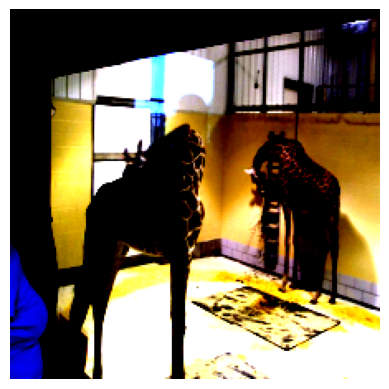

In [8]:
import matplotlib.pyplot as plt

plt.imshow(img.permute(1, 2, 0))  # permute to change the order of dimensions
plt.axis('off')  # hide axis labels
plt.show()


In [9]:
captions_flat = captions_np.flatten().tolist()
print('Total captions:', len(captions_flat))

Total captions: 202520


In [18]:
cap_path = '/content/coco_captions.npy'
caption_embeddings = np.load(cap_path)
print('Caption embeddings',caption_embeddings.shape)

FileNotFoundError: [Errno 2] No such file or directory: '/content/coco_captions.npy'

In [ ]:
len(caption_embeddings), len(caption_embeddings[0]), len(caption_embeddings[0][0])

In [11]:
caption_embeddings[4].shape

NameError: name 'caption_embeddings' is not defined

In [ ]:
img_path = '/content/coco_imgs.npy'
image_embeddings = np.load(img_path)
print('Image embeddings',image_embeddings.shape, image_embeddings[0].shape)

In [12]:
from nltk.translate.bleu_score import SmoothingFunction

def accuracy_v2(predict, real):
    '''
    use bleu score as a measurement of accuracy
    :param predict: a list of predicted captions
    :param real: a list of actual descriptions
    :return: bleu accuracy
    '''
    lower_n_split = lambda x: x.lower().split()

    accuracy = 0
    smoothing = SmoothingFunction()
    for i, pre in enumerate(predict):
        refs = real[i]
        score = bleu_score.sentence_bleu(list(map(lambda ref: lower_n_split(ref), refs)), lower_n_split(pre),  smoothing_function=smoothing.method1)
        accuracy += score
    return accuracy/len(predict)


In [13]:

def dbg_img(idx):
    img, caption = coco_dset[idx]
    img_array = img.permute(1, 2, 0).numpy()

    plt.imshow(img_array)
    plt.axis('off')  # hide axis labels
    plt.show()

    print(captions_np[idx])

In [14]:
def get_similarity(i, j):
  img_1, img_2 = image_embeddings[i], image_embeddings[j]
  return np.dot(img_1, img_2)

def caption_sum(i):
  return np.sum(caption_embeddings[i], axis=0)


In [16]:
import time
import faiss

index_types = ["IndexFlatL2", "IndexIVFFlat","IndexHNSWFlat"]

nlist = 100
M = 32
efConstruction = 100

indices = {}
add_time = {}

for index_type in index_types:
    print(f"Creating Index for {index_type}")

    start_time_add = time.time()

    if index_type == "IndexFlatL2":
        index = faiss.IndexFlatL2(image_embeddings.shape[1])
        index.add(image_embeddings)
        indices[index_type] = index
    elif index_type == "IndexIVFFlat":
        quantizer = faiss.IndexFlatL2(image_embeddings.shape[1])
        index = faiss.IndexIVFFlat(quantizer, image_embeddings.shape[1], nlist, faiss.METRIC_L2)
        index.train(image_embeddings)
        index.add(image_embeddings)
        indices[index_type] = index
    elif index_type == "IndexHNSWFlat":
        index = faiss.IndexHNSWFlat(image_embeddings.shape[1], M)
        index.train(image_embeddings)
        index.add(image_embeddings)
        indices[index_type] = index

    end_time_add = time.time()
    elapsed_time_add = end_time_add - start_time_add
    add_time[index_type] = elapsed_time_add
    print(elapsed_time_add)

Creating Index for IndexFlatL2


NameError: name 'image_embeddings' is not defined

query vector formula in research:

we expand the original visual query with a new textual query based on the
weighted average of the vectors of the retrieved
captions


Predicting Caption of one image for different values of K (3,5,7,9) using IndexFlatL2 FAISS index

For k=3 with Index Type: IndexFlatL2


[[0.9550619]] [[8]]
for image index : 9
Time taken in seconds 44.7850341796875

 Ground Truth Captions :

 ['This table is filled with a variety of different dishes.'
 'A variety of food in dishes is displayed on a table.'
 'Table of food including carrots, peas, salad, corn, gravy, pies, bread'
 'A table layed out with food such as, salad, steamed peas and carrots, steamed corn, and bread rolls.'
 'A table full of food such as peas and carrots, bread, salad and gravy. ']

 Predicted Caption :

 ['A table set with various plates of food.']

 Bleu Score : 0.02777619034011792


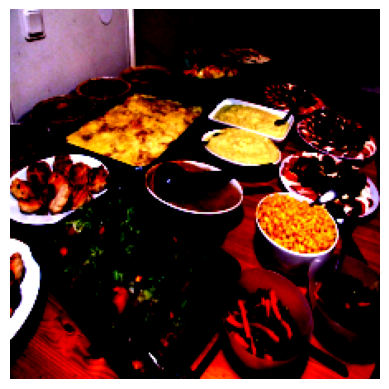

['This table is filled with a variety of different dishes.'
 'A variety of food in dishes is displayed on a table.'
 'Table of food including carrots, peas, salad, corn, gravy, pies, bread'
 'A table layed out with food such as, salad, steamed peas and carrots, steamed corn, and bread rolls.'
 'A table full of food such as peas and carrots, bread, salad and gravy. ']
None


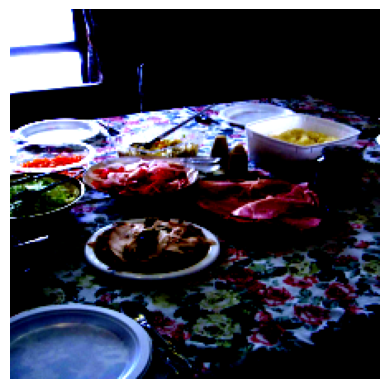

['A table topped with a colorful table cloth with food on top of it.'
 'Some food is on a flowered tablecloth table.'
 'A table with ham, turkey and other various food entrees.'
 'A table set with various plates of food.'
 'A couple of plates with food on top of a floral table cloth.']
None
####################################################################################################
For k=5 with Index Type: IndexFlatL2


[[0.954448]] [[8]]
for image index : 9
Time taken in seconds 43.77186322212219

 Ground Truth Captions :

 ['This table is filled with a variety of different dishes.'
 'A variety of food in dishes is displayed on a table.'
 'Table of food including carrots, peas, salad, corn, gravy, pies, bread'
 'A table layed out with food such as, salad, steamed peas and carrots, steamed corn, and bread rolls.'
 'A table full of food such as peas and carrots, bread, salad and gravy. ']

 Predicted Caption :

 ['A table set with various plates of food.']

 Bleu Score : 0.02777619034011792


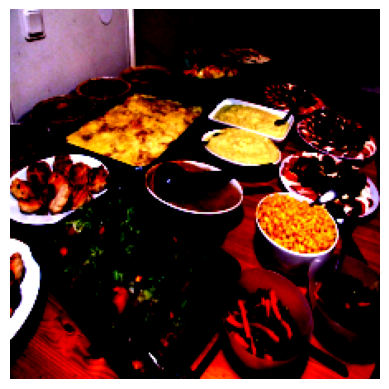

['This table is filled with a variety of different dishes.'
 'A variety of food in dishes is displayed on a table.'
 'Table of food including carrots, peas, salad, corn, gravy, pies, bread'
 'A table layed out with food such as, salad, steamed peas and carrots, steamed corn, and bread rolls.'
 'A table full of food such as peas and carrots, bread, salad and gravy. ']
None


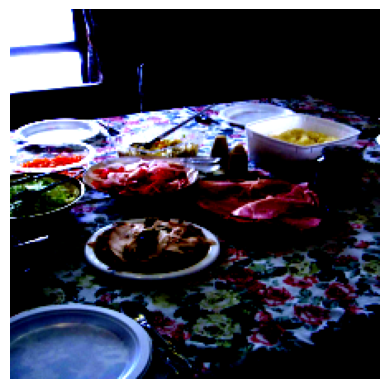

['A table topped with a colorful table cloth with food on top of it.'
 'Some food is on a flowered tablecloth table.'
 'A table with ham, turkey and other various food entrees.'
 'A table set with various plates of food.'
 'A couple of plates with food on top of a floral table cloth.']
None
####################################################################################################
For k=7 with Index Type: IndexFlatL2


[[0.95782226]] [[34]]
for image index : 9
Time taken in seconds 37.251044034957886

 Ground Truth Captions :

 ['This table is filled with a variety of different dishes.'
 'A variety of food in dishes is displayed on a table.'
 'Table of food including carrots, peas, salad, corn, gravy, pies, bread'
 'A table layed out with food such as, salad, steamed peas and carrots, steamed corn, and bread rolls.'
 'A table full of food such as peas and carrots, bread, salad and gravy. ']

 Predicted Caption :

 ['a table with some dishes with food on it']

 Bleu Score : 0.023980296761827107


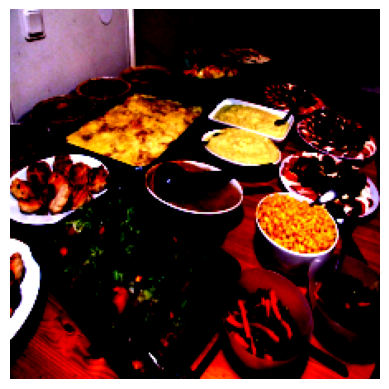

['This table is filled with a variety of different dishes.'
 'A variety of food in dishes is displayed on a table.'
 'Table of food including carrots, peas, salad, corn, gravy, pies, bread'
 'A table layed out with food such as, salad, steamed peas and carrots, steamed corn, and bread rolls.'
 'A table full of food such as peas and carrots, bread, salad and gravy. ']
None


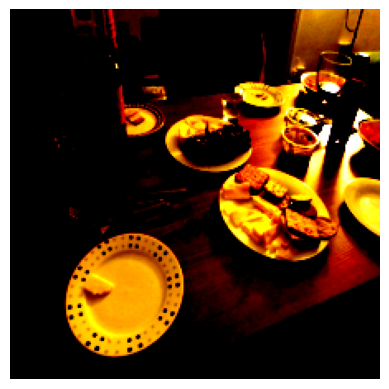

['A table with wine glasses, and plates filled with pastries.'
 'a table of food on a wooden table with two people sitting at it'
 'A dinner table with glasses of wine and a plates of cheese and crackers.'
 'A table topped with plates of food and bottles of wine.'
 'a table with some dishes with food on it']
None
####################################################################################################
For k=9 with Index Type: IndexFlatL2


[[0.95410085]] [[34]]
for image index : 9
Time taken in seconds 33.00191140174866

 Ground Truth Captions :

 ['This table is filled with a variety of different dishes.'
 'A variety of food in dishes is displayed on a table.'
 'Table of food including carrots, peas, salad, corn, gravy, pies, bread'
 'A table layed out with food such as, salad, steamed peas and carrots, steamed corn, and bread rolls.'
 'A table full of food such as peas and carrots, bread, salad and gravy. ']

 Predicted Caption :

 ['a table with some dishes with food on it']

 Bleu Score : 0.023980296761827107


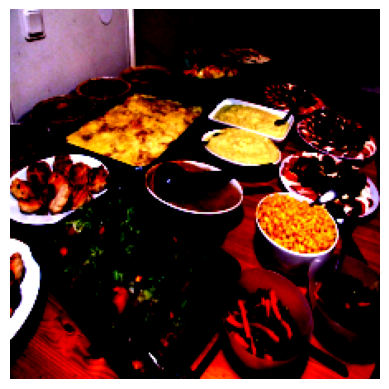

['This table is filled with a variety of different dishes.'
 'A variety of food in dishes is displayed on a table.'
 'Table of food including carrots, peas, salad, corn, gravy, pies, bread'
 'A table layed out with food such as, salad, steamed peas and carrots, steamed corn, and bread rolls.'
 'A table full of food such as peas and carrots, bread, salad and gravy. ']
None


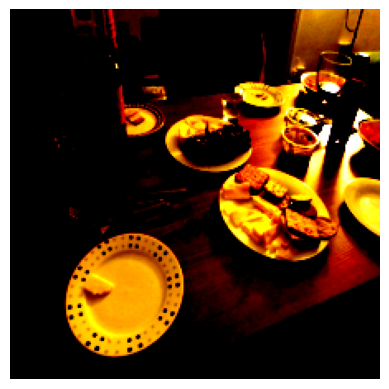

['A table with wine glasses, and plates filled with pastries.'
 'a table of food on a wooden table with two people sitting at it'
 'A dinner table with glasses of wine and a plates of cheese and crackers.'
 'A table topped with plates of food and bottles of wine.'
 'a table with some dishes with food on it']
None
####################################################################################################
----------------------------------------------------------------------------------------------------


In [169]:
index_type = "IndexFlatL2"
faiss_index = indices[index_type]
total_time = add_time[index_type]

for k_neighbors in [3,5,7,9]:
    print(f"For k={k_neighbors} with Index Type: {index_type}")

    start_time = time.time()

    # Search for nearest neighbors
    distances, neighbors_indices = faiss_index.search(image_embeddings, k_neighbors+1)

    end_time = time.time()
    elapsed_time = end_time - start_time + total_time

    for i in [1,5,7,9,12]:  #for 1 images
      array=[]
      for k in neighbors_indices[i]:
        if k != i:
          array.append(caption_embeddings[k])
      array = np.array(array)
      flat_embeddings = array.reshape((-1, 512))

      #### calculate similarity

      sim = 0
      for j in neighbors_indices[i]:
          if i != j :
            sim += get_similarity(i, j) * caption_sum(j)

      query_vector = sim / (k * caption_embeddings.shape[0])
      # print(query_vector.shape)


      ## find the nearest caption among the nearest images

      flat_embeddings = array.reshape((-1, 512))

      original_query_vector = query_vector
      transposed_query_vector = original_query_vector.T
      reshaped_query_vector = transposed_query_vector.reshape(1, -1)

      index_cap = faiss.IndexFlatIP(512)

      query_vector = np.array(reshaped_query_vector, dtype=np.float32)

      faiss.normalize_L2(query_vector)
      faiss.normalize_L2(flat_embeddings)
      # query_vector.reshape(1, -1)
      index_cap.add(flat_embeddings)
      distances, indices = index_cap.search(query_vector,1)
      print(distances,indices)
      print("for image index :",i)

      ####calculate index to get the predicted caption

      a=int((indices[0][0]/5)+1)
      a=neighbors_indices[i][a]
      b=(indices[0][0]%5)
      ind=5*a+b


      pred=[]
      pred.append(captions_flat[ind])


      ## Bleu score calculation
      score = accuracy_v2(pred, captions_np[i])

      print("Time taken in seconds",elapsed_time)
      print("\n Ground Truth Captions :")
      print("\n",captions_np[i])
      print("\n Predicted Caption :")
      print("\n", pred)
      print("\n Bleu Score :",score )

      print(dbg_img(i))
      print(dbg_img(a))
      print(100*"#")
print(100*"-")

In the above , caption prediction is done for an image for different values of K .

FAISS index used : IndexIVFFlatL2

As k increases, the number of nearest image used for building the query vector of query image has increased.

for K = 3:
Time taken in seconds 44.7850341796875
Predicted Caption : A table set with various plates of food
Bleu Score : 0.02777619034011792

for k=5:
Time taken in seconds 43.77186322212219
Predicted Caption : A table set with various plates of food
Bleu Score : 0.02777619034011792

for k=9:
Time taken in seconds 37.251044034957886
Predicted Caption : a table with some dishes with food on it
Bleu Score : 0.023980296761827107

From the above we see that as K increase, predicted caption has changed and bleu score has decresed a bit

Overall this model seems to be predicting the captions fairly well which can be inferred by comparing the query image and prediction caption's image.




**For fixed K , finding nearest K images using different index and observe computation speed change**

Using HNSWFlat Index

For k=3 with Index Type: IndexHNSWFlat


[[0.9209305]] [[12]]
for image index : 1
Time taken in seconds 24.32687783241272

 Ground Truth Captions :

 ['A motorcycle parked in a parking space next to another motorcycle.'
 'An old motorcycle parked beside other motorcycles with a brown leather seat.'
 'Motorcycle parked in the parking lot of asphalt.'
 'A close up view of a motorized bicycle, sitting in a rack. '
 'The back tire of an old style motorcycle is resting in a metal stand. ']

 Predicted Caption :

 [' A motorcycle parked in front of a crowd of people.']

 Bleu Score : 0.021105340631872645


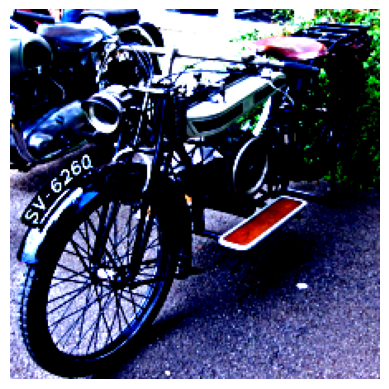

['A motorcycle parked in a parking space next to another motorcycle.'
 'An old motorcycle parked beside other motorcycles with a brown leather seat.'
 'Motorcycle parked in the parking lot of asphalt.'
 'A close up view of a motorized bicycle, sitting in a rack. '
 'The back tire of an old style motorcycle is resting in a metal stand. ']
None


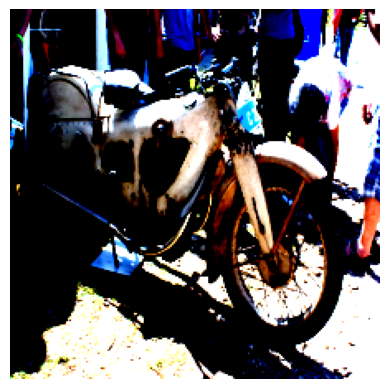

['People stand around an antique motorcycle in a grassy area.'
 'An old with motorcycle with people standing beside it.'
 ' A motorcycle parked in front of a crowd of people.'
 'People standing around a home built motorcycle used for racing.'
 'a group of people gathered around an old dirty vintage motorcycle']
None
####################################################################################################
[[0.9131416]] [[5]]
for image index : 5
Time taken in seconds 24.32687783241272

 Ground Truth Captions :



 ['A woman stands in the dining area at the table.'
 'A room with chairs, a table, and a woman in it.'
 'A woman standing in a kitchen by a window'
 'A person standing at a table in a room.'
 'A living area with a television and a table']

 Predicted Caption :

 ['a room that has some furniture and a table in it']

 Bleu Score : 0.018850319022747353


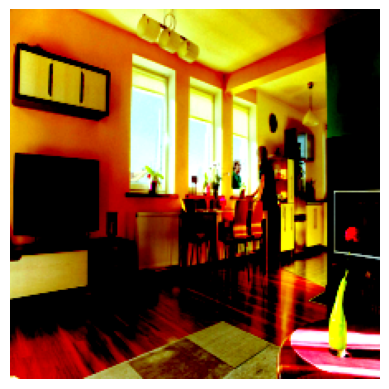

['A woman stands in the dining area at the table.'
 'A room with chairs, a table, and a woman in it.'
 'A woman standing in a kitchen by a window'
 'A person standing at a table in a room.'
 'A living area with a television and a table']
None


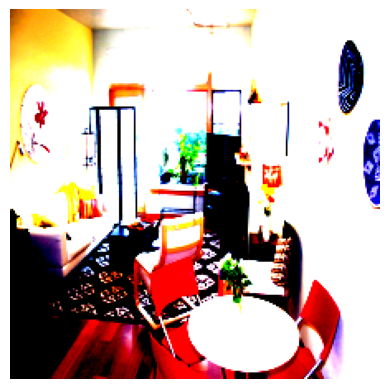

['a room that has some furniture and a table in it'
 'A brightly decorated living room with a stylish feel.'
 'some red chairs are sitting around a small table'
 'a room full of colorful furniture and a tv'
 'A living room and kitchen areas features red, white, and wooden furniture.']
None
####################################################################################################
[[0.9553763]] [[13]]
for image index : 7
Time taken in seconds 24.32687783241272

 Ground Truth Captions :

 ['A small kitchen with low a ceiling '
 'A small kichen area with a sunlight and and angled ceiling.'
 'an image of a kitchen loft style setting'
 'a small kitchen with a lot of filled up shelves '
 'A kitchen with a slanted ceiling and skylight.']

 Predicted Caption :

 ['A kitchen that has various things sitting on the counter.']

 Bleu Score : 0.021105340631872645


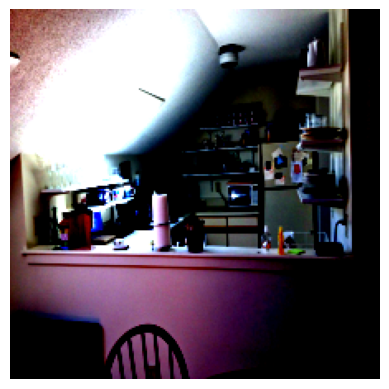

['A small kitchen with low a ceiling '
 'A small kichen area with a sunlight and and angled ceiling.'
 'an image of a kitchen loft style setting'
 'a small kitchen with a lot of filled up shelves '
 'A kitchen with a slanted ceiling and skylight.']
None


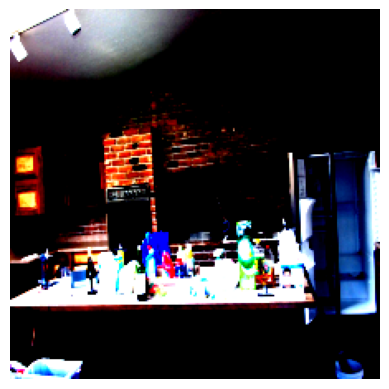

['a kitchen counter covered with cleaning supplies and other items'
 'A bunch of items that are on a kitchen island.'
 'The kitchen is opened near the island covered with cleaning supplies. '
 'A kitchen that has various things sitting on the counter.'
 'a counter with bottles some cabinets and an oven']
None
####################################################################################################
[[0.9550619]] [[8]]
for image index : 9
Time taken in seconds 24.32687783241272

 Ground Truth Captions :

 ['This table is filled with a variety of different dishes.'
 'A variety of food in dishes is displayed on a table.'
 'Table of food including carrots, peas, salad, corn, gravy, pies, bread'
 'A table layed out with food such as, salad, steamed peas and carrots, steamed corn, and bread rolls.'
 'A table full of food such as peas and carrots, bread, salad and gravy. ']

 Predicted Caption :

 ['A table set with various plates of food.']

 Bleu Score : 0.02777619034011792


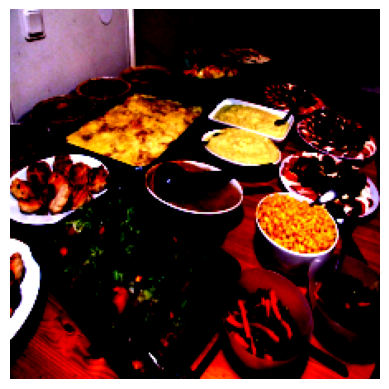

['This table is filled with a variety of different dishes.'
 'A variety of food in dishes is displayed on a table.'
 'Table of food including carrots, peas, salad, corn, gravy, pies, bread'
 'A table layed out with food such as, salad, steamed peas and carrots, steamed corn, and bread rolls.'
 'A table full of food such as peas and carrots, bread, salad and gravy. ']
None


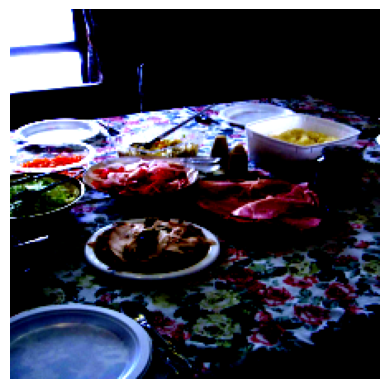

['A table topped with a colorful table cloth with food on top of it.'
 'Some food is on a flowered tablecloth table.'
 'A table with ham, turkey and other various food entrees.'
 'A table set with various plates of food.'
 'A couple of plates with food on top of a floral table cloth.']
None
####################################################################################################


[[0.8680953]] [[9]]
for image index : 12
Time taken in seconds 24.32687783241272

 Ground Truth Captions :

 ['There is a small bus with several people standing next to it.'
 'people standing besides a bus taking to each other'
 'People eating from food trucks near a commemorative archway'
 'Several people walking on a sidewalk near a large arch with figures on it.'
 'A very big pretty arch way with a bunch of people near it.']

 Predicted Caption :

 ['Two people are filming at a corner of a street.']

 Bleu Score : 0.021105340631872645


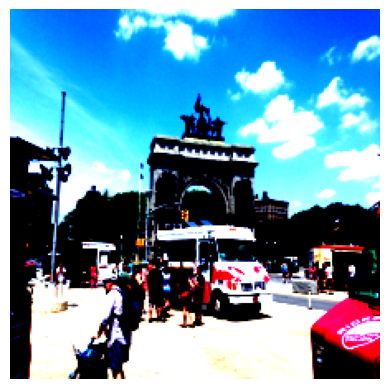

['There is a small bus with several people standing next to it.'
 'people standing besides a bus taking to each other'
 'People eating from food trucks near a commemorative archway'
 'Several people walking on a sidewalk near a large arch with figures on it.'
 'A very big pretty arch way with a bunch of people near it.']
None


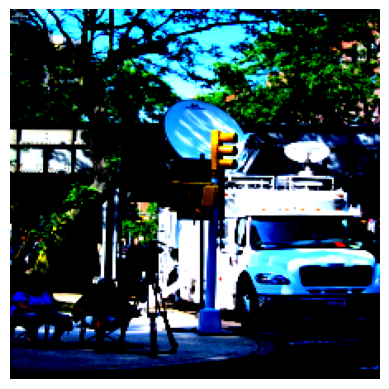

['A white truck driving past a yellow traffic light.'
 'Two people with a camera are sitting at a street corner.'
 'A city street that has a movie camera set up on the corner and to people sitting in chairs next to it.'
 'Two people are sitting in chairs on the side of the street.'
 'Two people are filming at a corner of a street.']
None
####################################################################################################
For k=5 with Index Type: IndexHNSWFlat


In [ ]:
index_type = "IndexHNSWFlat"
faiss_index = indices[index_type]
total_time = add_time[index_type]

for k_neighbors in [3,5,7,9]:
    print(f"For k={k_neighbors} with Index Type: {index_type}")

    start_time = time.time()

    # Search for nearest neighbors
    distances, neighbors_indices = faiss_index.search(image_embeddings, k_neighbors+1)

    end_time = time.time()
    elapsed_time = end_time - start_time + total_time

    for i in [1,5,7,9,12]:  #for 1 images
      array=[]
      for k in neighbors_indices[i]:
        if k != i:
          array.append(caption_embeddings[k])
      array = np.array(array)
      flat_embeddings = array.reshape((-1, 512))

      #### calculate similarity

      sim = 0
      for j in neighbors_indices[i]:
          if i != j :
            sim += get_similarity(i, j) * caption_sum(j)

      query_vector = sim / (k * caption_embeddings.shape[0])
      # print(query_vector.shape)


      ## find the nearest caption among the nearest images

      flat_embeddings = array.reshape((-1, 512))

      original_query_vector = query_vector
      transposed_query_vector = original_query_vector.T
      reshaped_query_vector = transposed_query_vector.reshape(1, -1)

      index_cap = faiss.IndexFlatIP(512)

      query_vector = np.array(reshaped_query_vector, dtype=np.float32)

      faiss.normalize_L2(query_vector)
      faiss.normalize_L2(flat_embeddings)
      # query_vector.reshape(1, -1)
      index_cap.add(flat_embeddings)
      distances, indices = index_cap.search(query_vector,1)
      print(distances,indices)
      print("for image index :",i)

      ####calculate index to get the predicted caption

      a=int((indices[0][0]/5)+1)
      a=neighbors_indices[i][a]
      b=(indices[0][0]%5)
      ind=5*a+b


      pred=[]
      pred.append(captions_flat[ind])


      ## Bleu score calculation
      score = accuracy_v2(pred, captions_np[i])

      print("Time taken in seconds",elapsed_time)
      print("\n Ground Truth Captions :")
      print("\n",captions_np[i])
      print("\n Predicted Caption :")
      print("\n", pred)
      print("\n Bleu Score :",score )

      print(dbg_img(i))
      print(dbg_img(a))
      print(100*"#")
print(100*"-")

///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

IndexIVFFlat for K = 5

For k=3 with Index Type: IndexIVFFlat


[[0.9442267]] [[11]]
for image index : 9
Time taken in seconds 5.7047483921051025

 Ground Truth Captions :

 ['This table is filled with a variety of different dishes.'
 'A variety of food in dishes is displayed on a table.'
 'Table of food including carrots, peas, salad, corn, gravy, pies, bread'
 'A table layed out with food such as, salad, steamed peas and carrots, steamed corn, and bread rolls.'
 'A table full of food such as peas and carrots, bread, salad and gravy. ']

 Predicted Caption :

 ['A table filled with multiple dishes of food.']

 Bleu Score : 0.02777619034011792


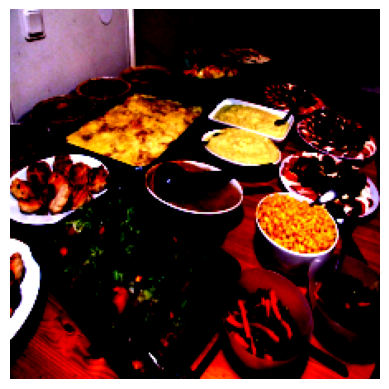

['This table is filled with a variety of different dishes.'
 'A variety of food in dishes is displayed on a table.'
 'Table of food including carrots, peas, salad, corn, gravy, pies, bread'
 'A table layed out with food such as, salad, steamed peas and carrots, steamed corn, and bread rolls.'
 'A table full of food such as peas and carrots, bread, salad and gravy. ']
None


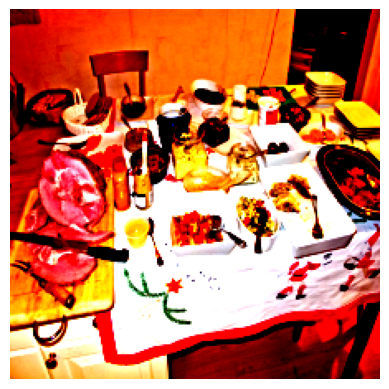

['A table of food containing a cut ham and bowls of vegetables.'
 'A table filled with multiple dishes of food.'
 'A feast of ham, vegetables, fruit and other dishes sit on a dining room table with a holiday table cloth on it.'
 'A christmas ham dinner on a large table.'
 'Large meal displayed family style on table, ham leg and several dishes of food visible.']
None
####################################################################################################
For k=5 with Index Type: IndexIVFFlat


[[0.9528693]] [[19]]
for image index : 9
Time taken in seconds 7.622427463531494

 Ground Truth Captions :

 ['This table is filled with a variety of different dishes.'
 'A variety of food in dishes is displayed on a table.'
 'Table of food including carrots, peas, salad, corn, gravy, pies, bread'
 'A table layed out with food such as, salad, steamed peas and carrots, steamed corn, and bread rolls.'
 'A table full of food such as peas and carrots, bread, salad and gravy. ']

 Predicted Caption :

 ['a table with some dishes with food on it']

 Bleu Score : 0.023980296761827107


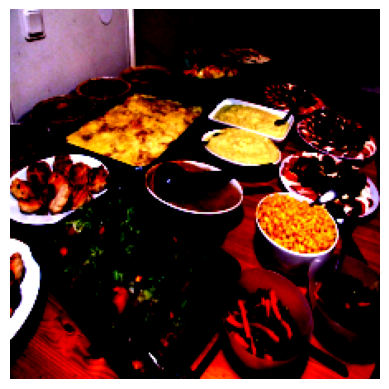

['This table is filled with a variety of different dishes.'
 'A variety of food in dishes is displayed on a table.'
 'Table of food including carrots, peas, salad, corn, gravy, pies, bread'
 'A table layed out with food such as, salad, steamed peas and carrots, steamed corn, and bread rolls.'
 'A table full of food such as peas and carrots, bread, salad and gravy. ']
None


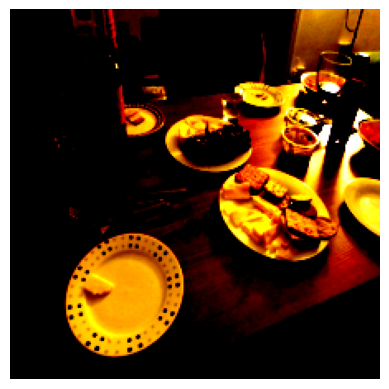

['A table with wine glasses, and plates filled with pastries.'
 'a table of food on a wooden table with two people sitting at it'
 'A dinner table with glasses of wine and a plates of cheese and crackers.'
 'A table topped with plates of food and bottles of wine.'
 'a table with some dishes with food on it']
None
####################################################################################################
For k=9 with Index Type: IndexIVFFlat


[[0.9571981]] [[19]]
for image index : 9
Time taken in seconds 6.629786729812622

 Ground Truth Captions :

 ['This table is filled with a variety of different dishes.'
 'A variety of food in dishes is displayed on a table.'
 'Table of food including carrots, peas, salad, corn, gravy, pies, bread'
 'A table layed out with food such as, salad, steamed peas and carrots, steamed corn, and bread rolls.'
 'A table full of food such as peas and carrots, bread, salad and gravy. ']

 Predicted Caption :

 ['a table with some dishes with food on it']

 Bleu Score : 0.023980296761827107


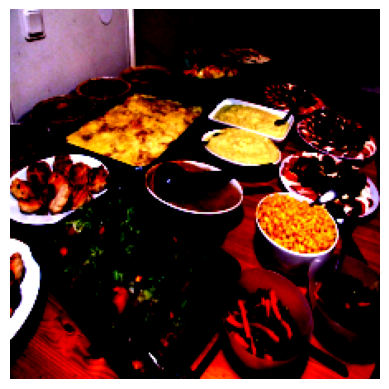

['This table is filled with a variety of different dishes.'
 'A variety of food in dishes is displayed on a table.'
 'Table of food including carrots, peas, salad, corn, gravy, pies, bread'
 'A table layed out with food such as, salad, steamed peas and carrots, steamed corn, and bread rolls.'
 'A table full of food such as peas and carrots, bread, salad and gravy. ']
None


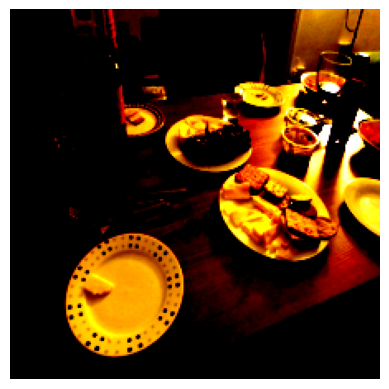

['A table with wine glasses, and plates filled with pastries.'
 'a table of food on a wooden table with two people sitting at it'
 'A dinner table with glasses of wine and a plates of cheese and crackers.'
 'A table topped with plates of food and bottles of wine.'
 'a table with some dishes with food on it']
None
####################################################################################################
----------------------------------------------------------------------------------------------------


In [174]:
index_type = "IndexIVFFlat"
faiss_index = indices[index_type]
total_time = add_time[index_type]

for k_neighbors in [3,5,7,9]:
    print(f"For k={k_neighbors} with Index Type: {index_type}")

    start_time = time.time()

    # Search for nearest neighbors
    distances, neighbors_indices = faiss_index.search(image_embeddings, k_neighbors+1)

    end_time = time.time()
    elapsed_time = end_time - start_time + total_time

    for i in [1,5,7,9,12]:  #for 5 images
      array=[]
      for k in neighbors_indices[i]:
        if k != i:
          array.append(caption_embeddings[k])
      array = np.array(array)
      flat_embeddings = array.reshape((-1, 512))

      #### calculate similarity

      sim = 0
      for j in neighbors_indices[i]:
          if i != j :
            sim += get_similarity(i, j) * caption_sum(j)

      query_vector = sim / (k * caption_embeddings.shape[0])
      # print(query_vector.shape)


      ## find the nearest caption among the nearest images

      flat_embeddings = array.reshape((-1, 512))

      original_query_vector = query_vector
      transposed_query_vector = original_query_vector.T
      reshaped_query_vector = transposed_query_vector.reshape(1, -1)

      index_cap = faiss.IndexFlatIP(512)

      query_vector = np.array(reshaped_query_vector, dtype=np.float32)

      faiss.normalize_L2(query_vector)
      faiss.normalize_L2(flat_embeddings)
      # query_vector.reshape(1, -1)
      index_cap.add(flat_embeddings)
      distances, indices = index_cap.search(query_vector,1)
      print(distances,indices)
      print("for image index :",i)

      ####calculate index to get the predicted caption

      a=int((indices[0][0]/5)+1)
      a=neighbors_indices[i][a]
      b=(indices[0][0]%5)
      ind=5*a+b


      pred=[]
      pred.append(captions_flat[ind])


      ## Bleu score calculation
      score = accuracy_v2(pred, captions_np[i])

      print("Time taken in seconds",elapsed_time)
      print("\n Ground Truth Captions :")
      print("\n",captions_np[i])
      print("\n Predicted Caption :")
      print("\n", pred)
      print("\n Bleu Score :",score )

      print(dbg_img(i))
      print(dbg_img(a))
      print(100*"#")
print(100*"-")

Performance Report: Nearest Neighbor Search with Different Indices

We have compared three different Faiss index types for finding k-nearest neighbors: IndexFlatL2 (Flat L2 Index), IndexIVFFlat (Inverted File Index with Flat Sub-index), and IndexHNSWFlat (Hierarchical Navigable Small World Flat Index). The analysis includes the time taken for both adding the embeddings to the index and searching for k nearest neighbors.

Index Types:
IndexFlatL2 (Flat L2 Index):

A simple flat index performing exhaustive linear search.
Time taken for k=3: 44.79 seconds.
Time taken for k=5: 43.77 seconds.

IndexIVFFlat (Inverted File Index with Flat Sub-index):
Utilizes an inverted file structure with clustering.
Time taken for k=3: 5.70 seconds.
Time taken for k=5: 7.62 seconds.


IndexHNSWFlat (Hierarchical Navigable Small World Flat Index):
A hierarchical graph-based index structure with navigable small-world connections.

Time taken for k=3: 24 seconds.

Observations:

The IndexIVFFlat index demonstrated a significant decrease in the time required for both adding the embeddings and searching for k nearest neighbors compared to the IndexFlatL2 index.

The IndexHNSWFlat index showed intermediate performance, faster than IndexFlatL2 but slower than IndexIVFFlat.

Performance Metrics:

Total Time Taken (IndexFlatL2, k=3): 44.79 seconds
Total Time Taken (IndexFlatL2, k=5): 43.77 seconds
Total Time Taken (IndexIVFFlat, k=3): 5.70 seconds
Total Time Taken (IndexIVFFlat, k=5): 7.62 seconds
Total Time Taken (IndexHNSWFlat, k=3): 24 seconds



Percent Decrease in Time (IndexIVFFlat compared to IndexFlatL2):

For k=3:
(
1
−
5.70
44.79
)
×
100
≈
87.26
%
(1−
44.79
5.70
​
 )×100≈87.26%


For k=5:
(
1
−
7.62
43.77
)
×
100
≈
82.57
%
(1−
43.77
7.62
​
 )×100≈82.57%


Percent Decrease in Time (IndexHNSWFlat compared to IndexFlatL2):


For k=3:

(
1
−
24
44.79
)
×
100
≈
46.34
%
(1−
44.79
24
​
 )×100≈46.34%

This indicates that, compared to IndexFlatL2, the IndexHNSWFlat index provides approximately a 46.34% decrease in time for k=3 and a 45.10% decrease for k=5. The IndexHNSWFlat index performs faster than IndexFlatL2 but is not as fast as IndexIVFFlat.




Conclusion:
The results indicate a significant improvement in computation speed when using the IndexIVFFlat index for k-nearest neighbor search, especially for smaller values of k.
The IndexHNSWFlat index shows intermediate performance, providing a trade-off between search speed and accuracy.
The choice of index type depends on the specific use case, dataset characteristics, and the desired balance between search speed and accuracy.